# 模式选择与欠拟合、过拟合
用一个多项式来验证

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。

In [5]:
max_degree = 20 #多项式的最大阶数
n_train , n_test = 100, 100 #训练和测试集的大小
true_w = np.zeros(max_degree) #分配空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1)) 
#使用 np.random.normal 函数生成一个形状为 (n_train + n_test, 1) 的二维数组 features，其中的元素服从标准正态分布（均值为 0，标准差为 1）。
#这个数组包含了训练集和测试集的所有特征数据。
np.random.shuffle(features) #随机打乱
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# np.arange(max_degree)：生成一个从 0 到 max_degree - 1 的一维数组。
# np.arange(max_degree).reshape(1, -1)：将上述一维数组转换为形状为 (1, max_degree) 的二维数组。
# np.power(features, np.arange(max_degree).reshape(1, -1))：使用 np.power 函数对 features 数组中的每个元素进行幂运算，
# 幂次由 np.arange(max_degree).reshape(1, -1) 提供。最终得到一个形状为 (n_train + n_test, max_degree) 的二维数组 poly_features，
# 其中第 i 列表示原始特征的 i 阶幂。
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
labels = np.dot(poly_features, true_w)
#np.dot(poly_features, true_w)：使用 np.dot 函数计算 poly_features 数组和 true_w 数组的点积，得到理论上的标签值。
labels += np.random.normal(scale = 0.1, size = labels.shape)

In [7]:
##从生成的数据集中查看一下前2个样本
true_w, features, poly_features, labels = [torch.tensor(x, dtype = torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]
#poly_features[:2, :] 第一个 : 表示对行的切片，[:2] 表示取前两行；第二个 : 表示对列的切片，: 表示取所有列。

(tensor([[ 1.3398],
         [-1.0906]]),
 tensor([[ 1.0000e+00,  1.3398e+00,  8.9748e-01,  4.0080e-01,  1.3425e-01,
           3.5972e-02,  8.0322e-03,  1.5373e-03,  2.5746e-04,  3.8326e-05,
           5.1347e-06,  6.2539e-07,  6.9823e-08,  7.1959e-09,  6.8863e-10,
           6.1506e-11,  5.1503e-12,  4.0589e-13,  3.0211e-14,  2.1303e-15],
         [ 1.0000e+00, -1.0906e+00,  5.9474e-01, -2.1621e-01,  5.8952e-02,
          -1.2859e-02,  2.3374e-03, -3.6418e-04,  4.9648e-05, -6.0163e-06,
           6.5616e-07, -6.5057e-08,  5.9128e-09, -4.9605e-10,  3.8643e-11,
          -2.8097e-12,  1.9152e-13, -1.2287e-14,  7.4448e-16, -4.2734e-17]]),
 tensor([5.8508, 0.3921]))

## 对模型进行训练和测试

In [10]:
def evaluate_loss(net, data_iter, loss):
    """ 评估给定数据集上模型的损失 """
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel()) #l.numel() 实际上就是当前批次中的样本数量
    return metric[0] / metric[1]

In [12]:
## 这是上一章的代码，然而在d2l中似乎没有封装进去，先加载下面代码再运行微调后的代码，可以通过。

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: 
        #len(y_hat.shape) > 1 检查 y_hat 是否为二维数组； 确认 y_hat 的第二维（通常是类别数）大于1，意味着有多个类别
        y_hat = y_hat.argmax(axis = 1)
        # 使用 argmax(axis=1) 找到每一行中最大值的索引，这个索引对应预测的类别。argmax 返回的是每行最大值的列索引，即预测的类别标签。
    cmp = y_hat.type(y.dtype) == y #逐元素比较预测类别与真实类别，生成一个布尔数组。由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。
    return float(cmp.type(y.dtype).sum())  # 结果是一个包含0（错）和1（对）的张量。
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n #初始化一个包含 n 个 0.0 的列表，用于存储累积的值
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] #对每一对 (a, b)，将 a（累加器中的当前值）和 b（新值）相加，并将结果转换成浮点数。
    def reset(self):
        self.data = [0.0] * len(self.data) #将 self.data 中的所有元素重置为 0.0，以便重新开始累积
    def __getitem__(self, idx):
        return self.data[idx] #允许使用索引访问 Accumulator 中的特定元素，例如 metric[0] 访问第一个累积值。
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):  
        net.train()  #net.train() 将模型设置为训练模式
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            # 在训练神经网络时，需要通过反向传播计算损失函数对模型参数的梯度，然后使用优化器根据这些梯度更新参数。优化器决定了每次更新的方向和幅度，从而影响模型的收敛速度和最终性能。
            updater.zero_grad()
            l.mean().backward()
            updater.step()
    #如果 updater 是 torch.optim.Optimizer 的实例，使用PyTorch内置的优化器进行梯度清零、反向传播和参数更新。
    #否则，使用自定义的 updater 函数进行反向传播和参数更新。
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())  #累加当前批次的损失总和、正确预测的数量和样本总数。
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [14]:
def train(train_features, test_features, train_labels, test_labels, num_epochs = 400):
    loss = nn.MSELoss(reduction = 'none')
#nn.MSELoss 是 PyTorch 中用于计算均方误差（Mean Squared Error，MSE）损失的类。
    #reduction='none' 表示不对计算得到的损失进行聚合（如求和、求平均等），而是返回每个样本的损失值。
    input_shape = train_features.shape[-1] #不设置偏置，因为我们在多项式中已经实现了它  train_features.shape[-1] 获取训练集特征张量最后一维的大小，即输入特征的维度。
    net = nn.Sequential(nn.Linear(input_shape, 1, bias = True))
    net = nn.Sequential(nn.Linear(input_shape, 1, bias = True)) 
#nn.Sequential 是一个容器，用于按顺序堆叠神经网络层。这里创建了一个包含单个线性层 nn.Linear 的模型，该线性层将输入特征从 input_shape 维映射到 1 维，并且设置 bias = True 表示包含偏置项。
    batch_size = min(10, train_labels.shape[0]) #batch_size 确定每次训练时使用的样本数量，取 10 和训练集标签数量的较小值
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size) #按批次获取数据
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train = False)
    trainer = torch.optim.SGD(net.parameters(), lr = 0.01)
    animator = d2l.Animator( xlabel = 'epoch', ylabel = 'loss',  yscale = 'log', xlim = [1, num_epochs], ylim = [1e-3, 1e2], legend = ['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer) #前向传播、计算损失、反向传播更新参数等操作
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))  #每 20 个轮次（以及第 0 轮次），调用 evaluate_loss 函数计算并记录当前模型在训练集和测试集上的损失，并使用 animator.add 将损失值添加到绘图器中，以便后续绘制损失曲线。
    print('weight:', net[0].weight.data.numpy()) #net[0].weight 获取模型中第一个（也是唯一的）线性层的权重张量，data 属性获取张量中的数据，numpy() 方法将数据转换为 NumPy 数组并打印输出，显示训练得到的模型权重。

weight: [[ 2.3353696  1.1820982 -3.4060113  5.6391706]]


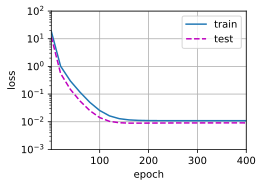

In [16]:
# 正常
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.1710732 3.798128 ]]


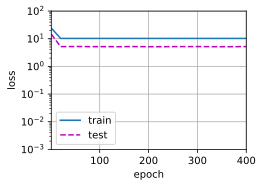

In [18]:
# 欠拟合
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 2.3226287   1.2962921  -3.4071984   5.050899   -0.06711192  1.5190252
   0.31213245  0.16235386  0.08036716  0.04772702  0.10987177  0.02060955
  -0.21115278  0.15178138 -0.06435291  0.00533531  0.18013038 -0.14832698
  -0.21871555  0.06830174]]


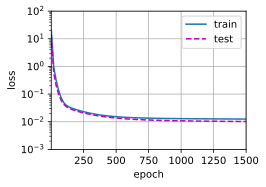

In [20]:
# 过拟合
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)